In [1]:
import os

import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

import librosa

from collections import Counter
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [2]:
# parameters
  # path_dir: 데이터셋 루트 경로
  # save_dir: annotation 데이터 저장 경로

path_dir = '../dataset/KEMDy20_v1_1'
save_dir = '../dataset/KEMDy20_v1_1/new/annotation'

In [3]:
# 필요한 폴더 생성

os.mkdir(path_dir+'/new')
os.mkdir(path_dir+'/new/annotation')
os.mkdir(path_dir+'/new/text')
os.mkdir(path_dir+'/new/wav')
os.mkdir(path_dir+'/new/sensor')
os.mkdir(path_dir+'/new/sensor/EDA')
os.mkdir(path_dir+'/new/sensor/Temp')
os.mkdir(path_dir+'/new/sensor/bio_train')

In [4]:
# 모든 segment_id에 따른 테이블 생성 (annotation)

anno_FList = os.listdir(path_dir+'/annotation')
file = anno_FList[0]
sess_num = 'Session'+file[4:6]
sess = pd.read_csv(path_dir+'/annotation/'+file, header=0, index_col=0, skiprows=[1], usecols=[0, 1, 2, 3, 4])
sess.columns = ['start', 'end', 'segment_id', 'emotion']
sess['seconds'] = sess.end - sess.start
sess.drop(labels=['start', 'end'], axis=1, inplace=True)

sess['sess'] = sess['segment_id'].str.split('_').str[0].str[-2:] # file[4:6]
sess['script'] = sess['segment_id'].str.split('_').str[1].str[-2:]
sess['gender'] = sess['segment_id'].str.split('_').str[2].str[-1:]
sess.head()

,segment_id,emotion,seconds,sess,script,gender
Numb,,,,,,
1,Sess01_script01_User002M_001,neutral,8.059001,01,01,M
2,Sess01_script01_User002M_002,neutral,11.697002,01,01,M
3,Sess01_script01_User002M_003,neutral,8.223999,01,01,M
4,Sess01_script01_User002M_004,neutral,11.411998,01,01,M
5,Sess01_script01_User001F_001,neutral,2.086000,01,01,F


In [5]:
# [20년도 데이터] 세션, 스크립트별 텍스트 확인, 파일 저장 코드

all_sess = pd.DataFrame(columns=['segment_id', 'emotion', 'seconds', 'sess', 'script'])
for file in tqdm(anno_FList):
  sess_num = 'Session'+file[4:6]
  sess = pd.read_csv(path_dir+'/annotation/'+file, header=0, index_col=0, skiprows=[1], usecols=[0, 1, 2, 3, 4])
  sess.columns = ['start', 'end', 'segment_id', 'emotion']
  sess['seconds'] = sess.end - sess.start
  sess.drop(labels=['start', 'end'], axis=1, inplace=True)
  sess['sess'] = sess['segment_id'].str.split('_').str[0].str[-2:] # file[4:6]
  sess['script'] = sess['segment_id'].str.split('_').str[1].str[-2:]
  

  all_sess = pd.concat([all_sess, sess], axis=0)
all_sess.sort_values(['sess', 'script'], inplace=True)
all_sess.reset_index(drop=True, inplace=True)
all_sess.to_pickle(save_dir+'/all_annotation.pkl')

100%|█████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 201.46it/s]


In [6]:
display(all_sess.head())
display(all_sess.tail())

,segment_id,emotion,seconds,sess,script
0,Sess01_script01_User002M_001,neutral,8.059001,01,01
1,Sess01_script01_User002M_002,neutral,11.697002,01,01
2,Sess01_script01_User002M_003,neutral,8.223999,01,01
3,Sess01_script01_User002M_004,neutral,11.411998,01,01
4,Sess01_script01_User001F_001,neutral,2.086000,01,01


,segment_id,emotion,seconds,sess,script
13457,Sess40_script06_User079F_043,neutral,5.49302,40,06
13458,Sess40_script06_User079F_044,neutral,2.65500,40,06
13459,Sess40_script06_User079F_045,neutral,6.57300,40,06
13460,Sess40_script06_User079F_046,neutral,2.69200,40,06
13461,Sess40_script06_User079F_047,neutral,2.24400,40,06


In [7]:
# [전처리 1] wav 결측 파일 삭제

#all_sess = pd.read_pickle(save_dir+'/all_annotation.pkl')

all_wav = []
for f_n in tqdm(all_sess.segment_id):
  sess = 'Session'+f_n[4:6]
  wav, sr = librosa.load(path_dir+'/wav/'+sess+'/'+f_n+'.wav', sr=16000)
  all_wav.append(wav)
all_sess['wav'] = all_wav

display(all_sess.head(2))

# 모두 0인 데이터 확인
all_sess['wav_sum'] = [sum(np.abs(wav_)) for wav_ in all_sess.wav.tolist()]

wav_loss_seg = all_sess.loc[all_sess['wav_sum']==0, 'segment_id'].tolist()
#print(wav_loss_seg)

all_sess = all_sess.loc[~all_sess['segment_id'].isin(wav_loss_seg)]
display(all_sess.head())
#print(all_sess.shape)

wav_loss_seg = all_sess.loc[all_sess['wav_sum']==0, 'segment_id'].tolist()
#print(wav_loss_seg)

all_sess = all_sess.loc[~all_sess['segment_id'].isin(wav_loss_seg)]
all_sess.drop(labels=['wav', 'wav_sum'], axis=1, inplace=True)
display(all_sess.head())
print(all_sess.shape)

#all_sess.to_pickle(save_dir+'/all_annotation.pkl')

100%|██████████████████████████████████████████████████████████████████████████| 13462/13462 [00:06<00:00, 1972.43it/s]


,segment_id,emotion,seconds,sess,script,wav
0,Sess01_script01_User002M_001,neutral,8.059001,01,01,"[0.052612305, 0.05267334, 0.051971436, 0.05163..."
1,Sess01_script01_User002M_002,neutral,11.697002,01,01,"[-0.0022888184, -0.0038452148, -0.004211426, -..."


,segment_id,emotion,seconds,sess,script,wav,wav_sum
0,Sess01_script01_User002M_001,neutral,8.059001,01,01,"[0.052612305, 0.05267334, 0.051971436, 0.05163...",4152.089264
1,Sess01_script01_User002M_002,neutral,11.697002,01,01,"[-0.0022888184, -0.0038452148, -0.004211426, -...",6209.839325
2,Sess01_script01_User002M_003,neutral,8.223999,01,01,"[-0.049682617, -0.054748535, -0.0574646, -0.05...",5556.708740
3,Sess01_script01_User002M_004,neutral,11.411998,01,01,"[-0.002380371, -0.0028381348, -0.0024719238, -...",6677.079102
4,Sess01_script01_User001F_001,neutral,2.086000,01,01,"[-0.0018310547, -0.0014648438, -0.0014038086, ...",430.743164


,segment_id,emotion,seconds,sess,script
0,Sess01_script01_User002M_001,neutral,8.059001,01,01
1,Sess01_script01_User002M_002,neutral,11.697002,01,01
2,Sess01_script01_User002M_003,neutral,8.223999,01,01
3,Sess01_script01_User002M_004,neutral,11.411998,01,01
4,Sess01_script01_User001F_001,neutral,2.086000,01,01


(13452, 5)


In [8]:
# [전처리 2] 센서 데이터 결측 파일 삭제

## 센서 데이터 (eda, temp) 불러와서 확인
# (1) EDA
eda_dir = path_dir+'/EDA' # path_dir
eda_sess_FList = os.listdir(eda_dir)
# 저장할 파일 경로
drop_eda_dir = path_dir+'/new/sensor/EDA/'

 # 세션에서 스크립트별로 나눠져있던 eda 데이터 합치기기
for folder in eda_sess_FList:
  lst = []
  sess_save=[] # ('session_number', 'EDA')
  eda_FList = os.listdir(eda_dir+'/'+folder)
  for script in eda_FList:
      with open(eda_dir+'/'+folder+'/'+script) as lines:
        b = list(map(str, script.split('_')))
        for line in lines:
          data = line.strip().split(',')
          if len(data)==3:
            a = list(map(str, data[2].split('_')))
            data[2] = data[2].replace(a[0],b[0])
            lst.append(data)
  df = pd.DataFrame(lst, columns=['data','date','sess'])
  df = df.astype({'data':float})  
  
  sess_name = df.sess.unique()
  for sess in sess_name:
    eda=list(df[df.sess == sess].data.values)
    sess_list = [sess, eda]
    sess_save.append(sess_list)
  sess_save_df = pd.DataFrame(sess_save, columns=['session', 'eda'])
  sess_save_df.to_pickle(drop_eda_dir+folder+'_eda.pkl')
    
# (2) Temp
temp_dir = path_dir+'/TEMP'
temp_sess_FList = os.listdir(temp_dir)
# 저장할 파일 경로
drop_temp_dir = path_dir+'/new/sensor/Temp/'

# 세션에서 스크립트별로 나눠져있던 temp 데이터 합치기
for folder in temp_sess_FList:
  lst = []
  sess_save=[] 
  temp_FList = os.listdir(temp_dir+'/'+folder)
  for script in temp_FList:
      with open(temp_dir+'/'+folder+'/'+script) as lines:
        b = list(map(str, script.split('_')))
        for line in lines:
          data = line.strip().split(',')
          if len(data)==3:
            a = list(map(str, data[2].split('_')))
            data[2] = data[2].replace(a[0],b[0])
            lst.append(data)
  df = pd.DataFrame(lst, columns=['data','date','sess'])
  df = df.astype({'data':float})  
  
  sess_name = df.sess.unique()
  for sess in sess_name:
    eda=list(df[df.sess == sess].data.values)
    sess_list = [sess, eda]
    sess_save.append(sess_list)

  sess_save_df = pd.DataFrame(sess_save, columns=['session', 'temp'])
  sess_save_df.to_pickle(drop_temp_dir+folder+'_temp.pkl')
    
eda_sess_FList = sorted(os.listdir(drop_eda_dir))
temp_sess_FList = sorted(os.listdir(drop_temp_dir))

all_bio = pd.DataFrame(columns=['segment_id','eda','temp'])

for eda, temp in zip(eda_sess_FList, temp_sess_FList):
  #print(eda, temp)
  TEMP = pd.read_pickle(path_dir+'/new/sensor/Temp/'+ temp )
  EDA = pd.read_pickle(path_dir+'/new/sensor/EDA/'+ eda )
  TEMP.columns = ['segment_id','temp']
  EDA.columns = ['segment_id','eda']
  bio = EDA.merge(TEMP, on = 'segment_id')
  all_bio = pd.concat([all_bio, bio], ignore_index=True)

#결측 파일
diff_seg = all_sess.merge(all_bio, on = 'segment_id', how='inner')

all_sess = all_sess.loc[all_sess['segment_id'].isin(diff_seg.segment_id.tolist())]
print(all_sess.shape)

(13381, 5)


['neutral' 'happy' 'surprise' 'angry' 'disgust' 'sad' 'fear']
(처리한 데이터) 감정 클래스에 대한 데이터 개수:


neutral     11060
happy        1171
surprise      156
angry         143
sad           121
disgust        60
fear           43
Name: emotion, dtype: int64

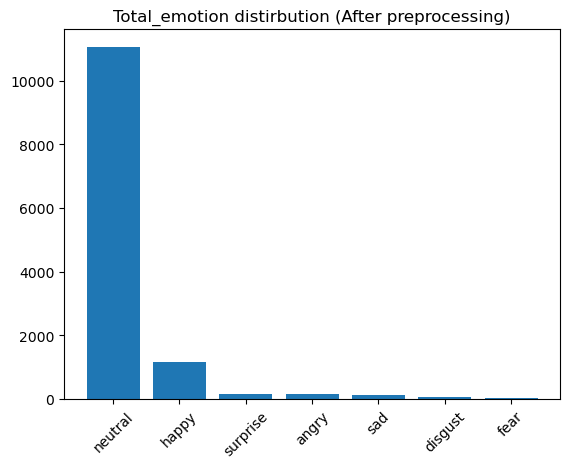

In [9]:
# [전처리 3] 멀티 클래스(분류된 감정 클래스 여러 개인 경우) 삭제 처리
pd.set_option('mode.chained_assignment',  None)

# 감정 두 개 이상 제외
filter_ = all_sess['emotion'].str.contains(";")
all_sess = all_sess[~filter_]

# disqust --> disgust (오타 처리)
all_sess.loc[all_sess.emotion=='disqust', 'emotion'] = 'disgust'
print(all_sess.emotion.unique())

## 시각화
print('(처리한 데이터) 감정 클래스에 대한 데이터 개수:')
display(all_sess.emotion.value_counts())

all_count = Counter(all_sess.emotion.tolist())
all_count = all_count.most_common()
labels = [x for (x, y) in all_count]
values = [y for (x, y) in all_count]

plt.bar(np.arange(len(labels)), values)
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.title('Total_emotion distirbution (After preprocessing)')
plt.show()

In [10]:
# Train:Test = 8:2 분할 (uni_emotion 데이터로)

all_sess['sess'] = all_sess['sess'].astype('int')
test_session = random.sample(range(1, 40), int(40*0.2)) #[29, 22, 6, 39, 4, 7, 15, 12] 
print('Test set - Sessions:', test_session)

train = all_sess.loc[~all_sess['sess'].isin(test_session), :]
test = all_sess.loc[all_sess['sess'].isin(test_session), :]

# save train, test pkl
train.reset_index(drop=True, inplace=True)
train.to_pickle(save_dir+'/train_origin.pkl')
print(train.shape)
display(train.tail())

test.reset_index(drop=True, inplace=True)
test.to_pickle(save_dir+'/test_origin.pkl')
print(test.shape)
display(test.tail())

Test set - Sessions: [29, 22, 6, 39, 4, 7, 15, 12]
(10140, 5)


,segment_id,emotion,seconds,sess,script
10135,Sess40_script06_User079F_043,neutral,5.49302,40,06
10136,Sess40_script06_User079F_044,neutral,2.65500,40,06
10137,Sess40_script06_User079F_045,neutral,6.57300,40,06
10138,Sess40_script06_User079F_046,neutral,2.69200,40,06
10139,Sess40_script06_User079F_047,neutral,2.24400,40,06


(2614, 5)


,segment_id,emotion,seconds,sess,script
2609,Sess39_script06_User077F_030,neutral,4.60600,39,06
2610,Sess39_script06_User077F_031,neutral,4.07800,39,06
2611,Sess39_script06_User077F_032,neutral,2.37600,39,06
2612,Sess39_script06_User077F_033,neutral,2.43700,39,06
2613,Sess39_script06_User077F_034,neutral,7.51602,39,06


In [11]:
# [전처리 4] 추가 전처리 (emotion_id 추가)

le = LabelEncoder()
le.fit(train.emotion.unique())
train['emotion_id'] = le.transform(train.emotion.tolist())
test['emotion_id'] = le.transform(test.emotion.tolist())

# 순서 변경
train = train[['segment_id', 'sess', 'script', 'seconds', 'emotion', 'emotion_id']]
test = test[['segment_id', 'sess', 'script', 'seconds', 'emotion', 'emotion_id']]

# sess column 수정
train['sess'] = train['segment_id'].str.split('_').str[0].str[-2:] # int --> str
test['sess'] = test['segment_id'].str.split('_').str[0].str[-2:]

train.to_pickle(save_dir+'/train_origin.pkl')
test.to_pickle(save_dir+'/test_origin.pkl')

display(train.head())
display(test.head())

train['fold'] = 'train'
test['fold'] = 'test'
all_sess = pd.concat([train, test], axis=0)
all_sess.to_pickle(save_dir+'/all_annotation.pkl')

,segment_id,sess,script,seconds,emotion,emotion_id
0,Sess01_script01_User002M_001,01,01,8.059001,neutral,4
1,Sess01_script01_User002M_002,01,01,11.697002,neutral,4
2,Sess01_script01_User002M_003,01,01,8.223999,neutral,4
3,Sess01_script01_User002M_004,01,01,11.411998,neutral,4
4,Sess01_script01_User001F_001,01,01,2.086000,neutral,4


,segment_id,sess,script,seconds,emotion,emotion_id
0,Sess04_script01_User007M_001,04,01,26.249999,neutral,4
1,Sess04_script01_User007M_002,04,01,8.505005,neutral,4
2,Sess04_script01_User007M_003,04,01,21.496994,neutral,4
3,Sess04_script01_User008F_001,04,01,5.090000,neutral,4
4,Sess04_script01_User008F_002,04,01,1.043000,neutral,4


In [ ]:
## + 데이터 탐색적 데이터 분석

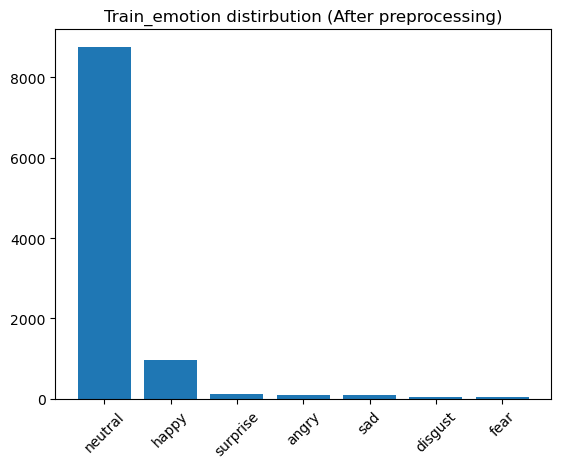

neutral     8750
happy        977
surprise     129
angry        105
sad           97
disgust       45
fear          37
Name: emotion, dtype: int64

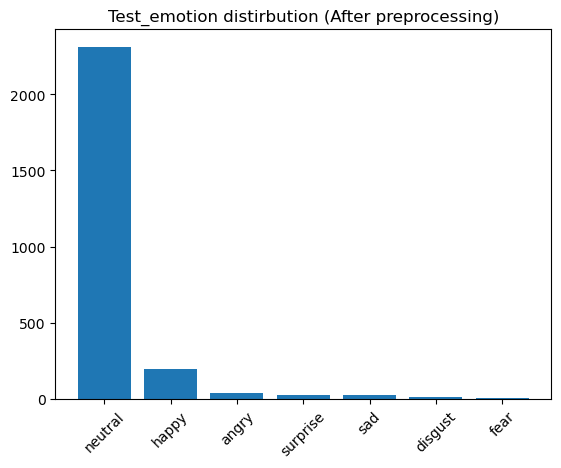

neutral     2310
happy        194
angry         38
surprise      27
sad           24
disgust       15
fear           6
Name: emotion, dtype: int64

In [12]:
# Train, Test set에 따른 클래스 불균형 확인
# Train
train_count = Counter(train.emotion.tolist())
train_count = train_count.most_common()
labels = [x for (x, y) in train_count]
values = [y for (x, y) in train_count]

plt.bar(np.arange(len(labels)), values)
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.title('Train_emotion distirbution (After preprocessing)')
plt.show()

display(train.emotion.value_counts())

# Test
test_count = Counter(test.emotion.tolist())
test_count = test_count.most_common()
labels = [x for (x, y) in test_count]
values = [y for (x, y) in test_count]

plt.bar(np.arange(len(labels)), values)
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.title('Test_emotion distirbution (After preprocessing)')
plt.show()

display(test.emotion.value_counts())

모든 데이터, 모든 클래스에 대한 발화 시간 분포


count    12754.000000
mean         5.898129
std          4.337874
min          0.671000
25%          2.748250
50%          4.519498
75%          7.729745
max         35.216000
Name: seconds, dtype: float64


모든 데이터, neutral 클래스에 대한 발화 시간 분포


count    11060.000000
mean         5.790759
std          4.293043
min          0.671000
25%          2.671000
50%          4.391003
75%          7.596003
max         35.216000
Name: seconds, dtype: float64


학습 데이터, 모든 클래스에 대한 발화 시간 분포


count    10140.000000
mean         5.941214
std          4.348458
min          0.671000
25%          2.776250
50%          4.557001
75%          7.793252
max         35.216000
Name: seconds, dtype: float64


학습 데이터, neutral 클래스에 대한 발화 시간 분포


count    8750.000000
mean        5.844971
std         4.313345
min         0.671000
25%         2.688001
50%         4.421995
75%         7.722492
max        35.216000
Name: seconds, dtype: float64

    bins  counts
0    0~4    4090
1    4~7    2409
2   7~11    1182
3  11~14     612
4  14~17     253
5  17~21     133
6  21~24      60
7  24~28       7
8  28~31       2
9  31~35       2


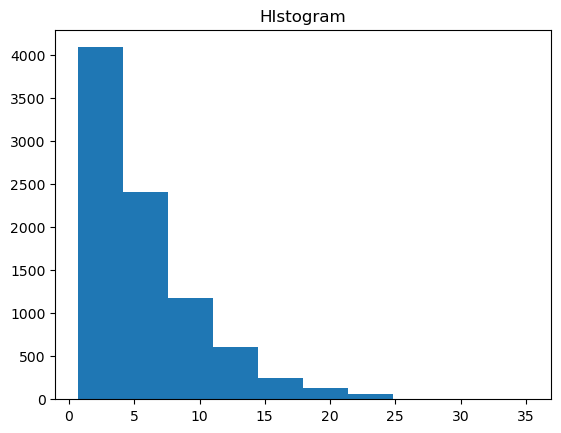

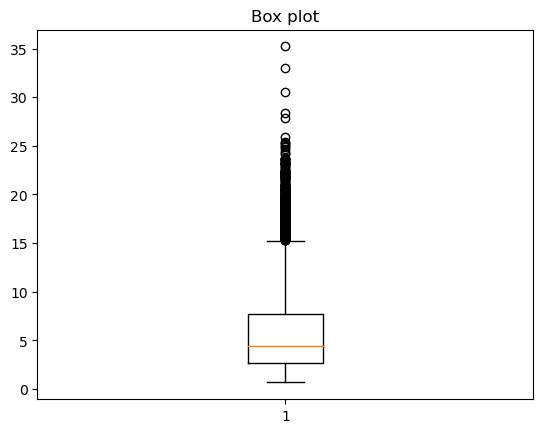

In [13]:
print('모든 데이터, 모든 클래스에 대한 발화 시간 분포')
display(all_sess.seconds.describe())

print('\n모든 데이터, neutral 클래스에 대한 발화 시간 분포')
display(all_sess.loc[all_sess['emotion']=='neutral', 'seconds'].describe())

print('\n학습 데이터, 모든 클래스에 대한 발화 시간 분포')
display(train.seconds.describe())

print('\n학습 데이터, neutral 클래스에 대한 발화 시간 분포')
neutral_time = train.loc[train['emotion']=='neutral', 'seconds']
display(neutral_time.describe())
counts, bins = np.histogram(neutral_time)

new_bins = []
for i in range(len(bins)-1):
  bin = str(int(bins[i]))+'~'+str(int(bins[i+1]))
  new_bins.append(bin)

hist_table = pd.DataFrame()
hist_table['bins'] = new_bins
hist_table['counts'] = counts
print(hist_table)

plt.hist(neutral_time)
plt.title('HIstogram')
plt.show()

plt.boxplot(neutral_time)
plt.title('Box plot')
plt.show()